Simulate two-modes schema for three-body-coupling in ordinary frame, consider com
mode only. 

In [1]:
import numpy as np
from qutip import *
import matplotlib.pyplot as plt
import Qsim.operator.spin as spin
import Qsim.operator.phonon as phon
import Qsim.ion_chain.ising.ising_c as iscc
import Qsim.operator.spin_phonon as sp_op
import Qsim.ion_chain.interaction.spin_phonon as Isp
from  Qsim.ion_chain.ion_system import *

In [2]:
ion_sys = Ions_asy( trap_config = {'N':3,'fx':3,'fz':1,'offset':200},
                   numeric_config = {'active_spin':[0,1,2], 'active_phonon':[[0],[0]],'pcut' : [[10],[10]]},)

ion_sys.list_para()

Trap coefficients updated
Anharmonic coefficients updated
_____________________________________________________________
Checking phonon space setup
Phonon space setups are consistent
_____________________________________________________________
Phonon space parameters updated
Cooling parameters updated
Trap parametric modulation updated
Ions class object initialized.
________________________________________________________________
********************Setup of the Trap************************
number of ions 3
Axial COM (Confining) frequency  1  [MHz]
Radial COM (Confining) frequency  3 [MHz]
Axial vibrational eigenfrequency [1.   1.73 2.41] MHz
Radial (Transverse) vibrational eigenfrequency (1st set) [3.    2.828 2.569] [MHz]
Radial (Transverse) vibrational eigenfrequency (2nd set) [3.2   3.028 2.769] [MHz]
Modulation Amplitude for parameteric amplification:  [0] [V]
Modulation Frequency for parameteric amplification:  [0] [MHz]
Trap dimension parameter:  200 [um]
                      

Laser parameters updated
Lasers class object initialized.
Laser parameters updated
Lasers class object initialized.
Laser parameters updated
Lasers class object initialized.
Laser parameters updated
Lasers class object initialized.
x Red Sideband
                                                                 
********************Parameters of Laser Drive************************
Vibrational degree of freedom couples to the laser: Transverse (Radial x)
index of ions that couple to the laser field:  [0, 1, 2]
Effective rabi frequency  0.79  [kHz]
Effective laser frequency  -3005.0  [kHz]
Laser phase phis 0.0
(input in rad but displayed in degs)
x Blue Sideband
                                                                 
********************Parameters of Laser Drive************************
Vibrational degree of freedom couples to the laser: Transverse (Radial x)
index of ions that couple to the laser field:  [0, 1, 2]
Effective rabi frequency  34.64  [kHz]
Effective laser frequency 

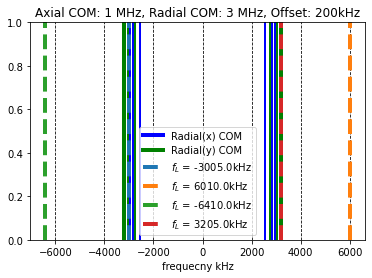

In [3]:
#%%
delta = 5

 
laser_xr = Laser(config = {'Omega_eff':0,'wavevector':1,'Dk':np.sqrt(2)*2*np.pi / (355*10**(-9)),
                         'laser_couple':[0,1,2], 'mu':-1*(delta+1e3*ion_sys.fx),'phase':0})

Omega_eff = 10*laser_xr.eta(ion_sys.fx) 
laser_xr.Omega_eff =  Omega_eff

laser_xb = Laser(config = {'Omega_eff':Omega_eff,
                           'wavevector':1,'Dk':np.sqrt(2)*2*np.pi / (355*10**(-9)),
                         'laser_couple':[0,1,2], 
                         'mu':2*(delta+1e3*ion_sys.fx)
                         ,'phase':0})

laser_yr = Laser(config = {'Omega_eff':Omega_eff,
                           'wavevector':2,'Dk':np.sqrt(2)*2*np.pi / (355*10**(-9)),
                         'laser_couple':[0,1,2], 
                         'mu':-2*(delta+1e3*ion_sys.radial_freq2[0]),
                         'phase':0})

laser_yb = Laser(config = {'Omega_eff':Omega_eff,
                           'wavevector':2,'Dk':np.sqrt(2)*2*np.pi / (355*10**(-9)),
                         'laser_couple':[0,1,2], 
                         'mu': (delta+1e3*ion_sys.radial_freq2[0]),
                         'phase':0})

#we want the coupling coefficients to be equal to Omega_eff
laser_xb.Omega_eff = 2*np.sqrt(3)*Omega_eff/laser_xr.eta(ion_sys.fx) 
laser_yr.Omega_eff = 2*np.sqrt(3)*Omega_eff/laser_xr.eta(ion_sys.radial_freq2[0]) 
#print parameters
print('=====================================')
print('x Red Sideband')
laser_xr.list_para()
print('=====================================')
print('x Blue Sideband')
laser_xb.list_para()
print('=====================================')
print('y Red Sideband')
laser_yr.list_para()
print('=====================================')
print('y Blue Sideband')
laser_yb.list_para()
ion_sys.plot_freq(show_axial = False, show_neg =  True , 
                  laser_list=[laser_xr,laser_xb,laser_yr,laser_yb])

In [6]:
#%%Construct Hamiltonian
Heff,arg = iscc.H_com_asy(ion_sys, laser_xr, laser_xb, laser_yr, laser_yb)
N = ion_sys.N
spin_config = np.array([1,1,1])
psi1 = sp_op.ini_state(ion_sys,s_state = spin_config, p_state = [[0],[0]], state_type=1)
elist_com = [tensor(spin.sz(N,0),sp_op.p_I(ion_sys)),
          tensor(spin.sz(N,1),sp_op.p_I(ion_sys)),
          tensor(spin.sz(N,2),sp_op.p_I(ion_sys))]
#solve time dependent SE
times =  np.arange(0,200,1e-1)
print('______________________________________________________________________')
print('solving time-dependent Hamiltonian')
result1 = sesolve(Heff,psi1,times,args = arg,progress_bar=True,options=Options(nsteps=10000)) 

______________________________________________________________________
solving time-dependent Hamiltonian
10.0%. Run time:   0.83s. Est. time left: 00:00:00:07
20.0%. Run time:   1.61s. Est. time left: 00:00:00:06
30.0%. Run time:   2.39s. Est. time left: 00:00:00:05
40.0%. Run time:   3.16s. Est. time left: 00:00:00:04
50.0%. Run time:   3.92s. Est. time left: 00:00:00:03
60.0%. Run time:   4.71s. Est. time left: 00:00:00:03
70.0%. Run time:   5.50s. Est. time left: 00:00:00:02
80.0%. Run time:   6.28s. Est. time left: 00:00:00:01
90.0%. Run time:   7.03s. Est. time left: 00:00:00:00
Total run time:   7.80s


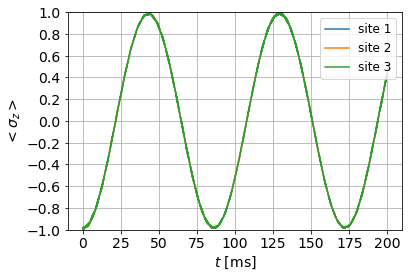

In [7]:
#%%
#plot spin evolution
p1 = expect(elist_com[0],result1.states)
p2 = expect(elist_com[1],result1.states)
p3 = expect(elist_com[2],result1.states)
plt.plot(times,p1,label = 'site 1')
plt.plot(times,p2,label = 'site 2')
plt.plot(times,p3,label = 'site 3')
plt.xlabel(r'$t$ [ms]',fontsize = 14)
plt.ylabel(r'$<\sigma_{z}>$',fontsize = 14)
plt.ylim(-1,1)
plt.yticks(np.arange(-1,1.2,0.2),fontsize = 14)
plt.xticks(fontsize = 14)
plt.legend(fontsize = 12)
plt.grid()
plt.show()

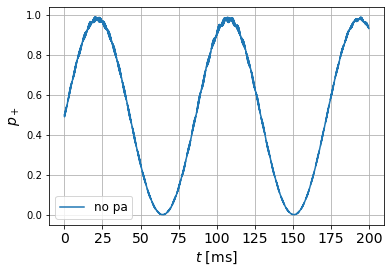

In [8]:
#%% plot projection on GHZ state
s1 = spin.spin_state(N,[0,0,0])
s2 = spin.spin_state(N,[1,1,1])
splus = 1/np.sqrt(2)*(s1+1j*s2)
proj1=tensor(splus*splus.dag(),sp_op.p_I(ion_sys))
pghz = expect(proj1,result1.states)
plt.plot(times,pghz,label = 'no pa')
plt.xlabel(r'$t$ [ms]',fontsize = 14)
plt.ylabel(r'$p_+$',fontsize = 14)
#plt.ylim(-1,1)
#plt.yticks(np.arange(-1,1.2,0.2),fontsize = 14)
plt.xticks(fontsize = 14)
plt.legend(fontsize = 12)
plt.grid()
plt.show() 

Estimated phonon cutoff error:  1.2e-08


<Figure size 432x288 with 0 Axes>

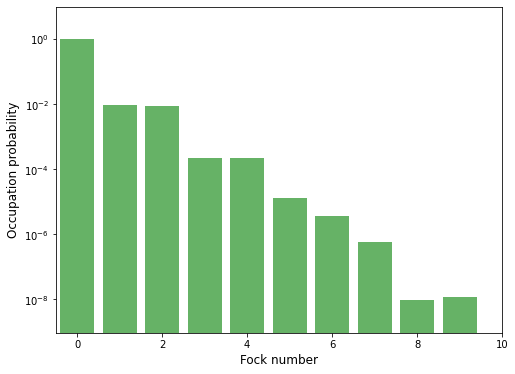

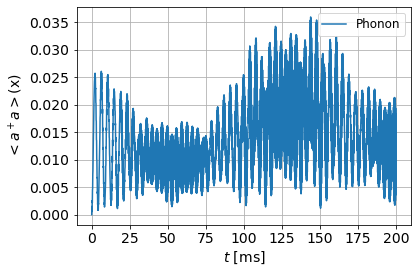

In [9]:
#%%phonon evolution
#x phonon modes
sp_op.phonon_cutoff_error(result1.states, ion_sys, df=1, mindex=0,plot=True)
pplot = expect(sp_op.phonon_measure(ion_sys,1,mindex=0), result1.states)
plt.plot(times,pplot,label = 'Phonon')
plt.xlabel(r'$t$ [ms]',fontsize = 14)
#title = r'$\delta_{com} = $'+str(ion_sys.delta)+' kHz'
plt.ylabel(r'$<a^+ a>$(x)',fontsize = 14)
#plt.title(title,fontsize = 14)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.legend(fontsize = 12)
plt.grid()
plt.show()

Estimated phonon cutoff error:  2e-09


<Figure size 432x288 with 0 Axes>

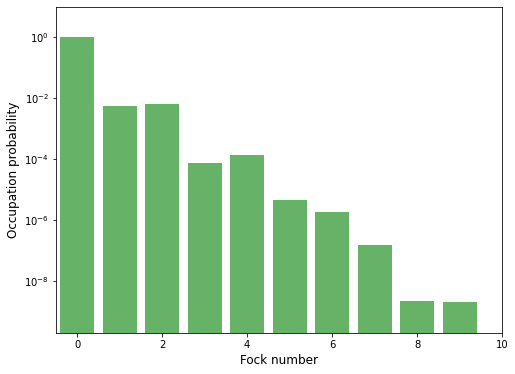

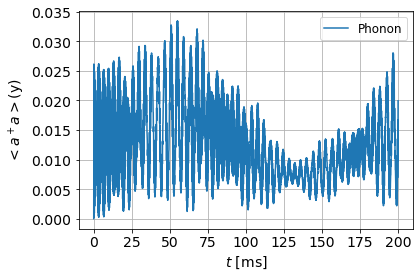

In [10]:
#%%phonon evolution
#y phonon modes
sp_op.phonon_cutoff_error(result1.states, ion_sys, df=2, mindex=0,plot=True)
pplot = expect(sp_op.phonon_measure(ion_sys,2,mindex=0), result1.states)
plt.plot(times,pplot,label = 'Phonon')
plt.xlabel(r'$t$ [ms]',fontsize = 14)
#title = r'$\delta_{com} = $'+str(ion_sys.delta)+' kHz'
plt.ylabel(r'$<a^+ a>$(y)',fontsize = 14)
#plt.title(title,fontsize = 14)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.legend(fontsize = 12)
plt.grid()
plt.show()